In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import psycopg2
import requests #package for getting data from the web
from zipfile import * #package for unzipping zip files
from sql import engine #adjust this as necessary to match your sql.py connection methods
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sql import query #get_data = query
from meteostat import Point, Daily
from meteostat import Stations

ModuleNotFoundError: No module named 'sql'

# 1. Download csv file with flight data for your specific year/month

In [2]:
# Specifies path for saving file
data_path ='data/' 
# Create the data folder
#!mkdir data

In [3]:
years = [2005] # list of years you want to look at, specify one year
months = [8] # list of months you want to look at, specify one month
# Here: September 2018

# Loop through months
for year in years:
    for month in months:
        # Get the file from the website https://transtats.bts.gov
        zip_file = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
        csv_file = f'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_{year}_{month}.csv'
        url = (f'https://transtats.bts.gov/PREZIP/{zip_file}')
        # Download the database
        r = requests.get(f'{url}', verify=False)
        # Save database to local file storage
        with open(data_path+zip_file, 'wb') as f:
            f.write(r.content)

In [4]:
# Unzip your file
with ZipFile(data_path+zip_file, 'r') as zip_ref:
    zip_ref.extractall(data_path)

In [5]:
# Read in your data
df = pd.read_csv(data_path+csv_file, low_memory = False)
display(df.shape)
display(df.head())

(630904, 110)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2005,3,8,20,6,2005-08-20,DL,19790,DL,N908DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005,3,8,20,6,2005-08-20,DL,19790,DL,N112DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005,3,8,20,6,2005-08-20,DL,19790,DL,N989DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005,3,8,20,6,2005-08-20,DL,19790,DL,N989DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005,3,8,20,6,2005-08-20,DL,19790,DL,N947DL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Prepare the csv file for further processing

In [6]:
columns_to_keep = [
                'FlightDate',
                'DepTime',
                'CRSDepTime',
                'DepDelay',
                'ArrTime',
                'CRSArrTime',
                'ArrDelay',
                'Reporting_Airline',
                'Tail_Number',
                'Flight_Number_Reporting_Airline',
                'Origin',
                'Dest',
                'AirTime',
                'Distance',
                'Cancelled',
                'Diverted'
]

In [7]:
# The columns in the DB have different naming as in the source csv files. Lets get the names from the DB
schema = 'muc_analytics_21_1'
table_name_sql = f'''SELECT COLUMN_NAME 
                    FROM INFORMATION_SCHEMA.COLUMNS
                    WHERE TABLE_NAME = 'flights'
                    AND TABLE_SCHEMA ='{schema}'
                    ORDER BY ordinal_position'''
c_names = engine.execute(table_name_sql).fetchall()
c_names

[('flight_date',),
 ('dep_time',),
 ('sched_dep_time',),
 ('dep_delay',),
 ('arr_time',),
 ('sched_arr_time',),
 ('arr_delay',),
 ('airline',),
 ('tail_number',),
 ('flight_number',),
 ('origin',),
 ('dest',),
 ('air_time',),
 ('distance',),
 ('cancelled',),
 ('diverted',)]

In [8]:
#we can clean up the results into a clean list
new_column_names=[]
for name in c_names:
    new_column_names.append(name[0])
new_column_names

['flight_date',
 'dep_time',
 'sched_dep_time',
 'dep_delay',
 'arr_time',
 'sched_arr_time',
 'arr_delay',
 'airline',
 'tail_number',
 'flight_number',
 'origin',
 'dest',
 'air_time',
 'distance',
 'cancelled',
 'diverted']

In [9]:
def clean_airline_df(df):
    '''
    Transforms a df made from BTS csv file into a df that is ready to be uploaded to SQL
    Set rows=0 for no filtering
    '''

    # Build dataframe including only the columns you want to keep
    df_airline = df.loc[:,columns_to_keep]
    
    # Clean data types and NULLs
    df_airline['FlightDate']= pd.to_datetime(df_airline['FlightDate'], yearfirst=True)
    df_airline['CRSArrTime']= pd.to_numeric(df_airline['CRSArrTime'], downcast='integer', errors='coerce')
    df_airline['Cancelled']= pd.to_numeric(df_airline['Cancelled'], downcast='integer')
    df_airline['Diverted']= pd.to_numeric(df_airline['Diverted'], downcast='integer')
    
    # Rename columns
    df_airline.columns = new_column_names
    
    return df_airline

In [10]:
# Call function and check resulting dataframe
df_clean = clean_airline_df(df)
df_clean.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,distance,cancelled,diverted
0,2005-08-20,728.0,720,8.0,1044.0,1016,28.0,DL,N908DL,992,SEA,SLC,92.0,689.0,0,0
1,2005-08-20,2036.0,2039,-3.0,2231.0,2239,-8.0,DL,N112DL,994,MIA,ATL,81.0,595.0,0,0
2,2005-08-20,749.0,750,-1.0,851.0,905,-14.0,DL,N989DL,995,CHS,ATL,54.0,259.0,0,0
3,2005-08-20,1024.0,1025,-1.0,1244.0,1248,-4.0,DL,N989DL,995,ATL,BDL,118.0,859.0,0,0
4,2005-08-20,732.0,735,-3.0,933.0,946,-13.0,DL,N947DL,997,MCO,CVG,105.0,756.0,0,0


In [11]:
# Specify the airports you are interested in and put them as a list in the function.
def select_airport(df, airports):
    ''' Helper function for filtering airline df for a subset of airports'''
    df_out = df.loc[(df.origin.isin(airports)) | (df.dest.isin(airports))]
    return df_out

Affected Area:
Florida [FLL,MIA,PBI,PNS,RWS]
Alabama [BHM]
OHIO [CMH,DAY]
KENTUCKY [CVG,SDF,LEX]
TENNESEE[BNA,MEM,TYS,CHA]
Louisiana[MSY]


Range other airports are effected from the Hurricane:

Filtering:

In [12]:
# Execute function, filtering for area airports affected
airports=['MSY', 'MEM', 'FLL','MIA','PBI','PNS']
if len(airports) > 0:
    df_selected_airports = select_airport(df_clean, airports)
else:
    df_selected_airports = df_clean
    
df_selected_airports.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,distance,cancelled,diverted
1,2005-08-20,2036.0,2039,-3.0,2231.0,2239,-8.0,DL,N112DL,994,MIA,ATL,81.0,595.0,0,0
20,2005-08-20,1217.0,1125,52.0,1440.0,1349,51.0,DL,N998DL,1013,MSY,ATL,67.0,425.0,0,0
25,2005-08-20,1239.0,1240,-1.0,1430.0,1430,0.0,DL,N841MH,1017,ATL,FLL,90.0,581.0,0,0
30,2005-08-20,1928.0,1930,-2.0,2147.0,2159,-12.0,DL,N922DL,1023,MSY,ATL,62.0,425.0,0,0
31,2005-08-20,723.0,725,-2.0,947.0,1006,-19.0,DL,N909DA,1024,MSY,SLC,182.0,1428.0,0,0


# 3. Push the prepared data to a table in the database

In [13]:
# Specify which table within your database you want to push your data to. Give your table an unambiguous name.
table_name = 'flights_katy'
# If the specified table doesn't exist yet, it will be created
# With 'replace', your data will be replaced if the table already exists.
# This will take a minute or two...

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        df_selected_airports.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        schema=schema, # Use schmea that was defined earlier
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The flights_katy table was imported successfully.


In [14]:
# Check the number of rows match
table_name_sql = f'''SELECT count(*) 
                    FROM {schema}.{table_name}
                    '''
#sql table row                                      #dateframe rows
engine.execute(table_name_sql).fetchall()[0][0] == df_selected_airports.shape[0]

True

# 4. EDA

## 4.1  Loading the data

<img src="./Image/sql_code.png" width=70% height=70%>

In [15]:
hurricane_katrina = get_data('SELECT * FROM muc_analytics_21_1.hurricane_katrina')
hurricane_katrina.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,...,country_origin,faa_dest,name_dest,lat_dest,lon_dest,alt_dest,tz_dest,dst_dest,city_dest,country
0,2005-08-20,2036.0,2039,-3.0,2231.0,2239,-8.0,DL,N112DL,994,...,United States,ATL,Hartsfield Jackson Atlanta International Airport,33.636700,-84.428101,1026,-5.0,A,Atlanta,United States
1,2005-08-20,732.0,735,-3.0,933.0,946,-13.0,DL,N947DL,997,...,United States,CVG,Cincinnati Northern Kentucky International Air...,39.048801,-84.667801,896,-5.0,A,Cincinnati,United States
2,2005-08-20,2128.0,1850,158.0,2337.0,2048,169.0,DL,N917DL,1004,...,United States,BDL,Bradley International Airport,41.938900,-72.683197,173,-5.0,A,Windsor Locks,United States
3,2005-08-20,616.0,620,-4.0,1130.0,1142,-12.0,DL,N914DN,1006,...,United States,CVG,Cincinnati Northern Kentucky International Air...,39.048801,-84.667801,896,-5.0,A,Cincinnati,United States
4,2005-08-20,848.0,850,-2.0,1328.0,1344,-16.0,DL,N3752,1011,...,United States,CVG,Cincinnati Northern Kentucky International Air...,39.048801,-84.667801,896,-5.0,A,Cincinnati,United States


## 4.2 Counting Null Values

In [16]:
#counting total missing values
hurricane_katrina.isnull().sum().sort_values(ascending = False)

air_time          4280
arr_time          4280
arr_delay         4280
dep_delay         3880
dep_time          3880
tail_number       2100
flight_date          0
dst_origin           0
city_origin          0
country_origin       0
faa_dest             0
name_dest            0
lon_dest             0
lat_dest             0
alt_origin           0
alt_dest             0
tz_dest              0
dst_dest             0
city_dest            0
tz_origin            0
name_origin          0
lon_origin           0
lat_origin           0
faa_origin           0
diverted             0
cancelled            0
distance             0
dest                 0
origin               0
flight_number        0
airline              0
sched_arr_time       0
sched_dep_time       0
country              0
dtype: int64

In [17]:
#counting null values from flights that have also been cancelled
hurricane_katrina[hurricane_katrina['cancelled'] == 1].isnull().sum().sort_values(ascending = False)

air_time          3880
dep_delay         3880
arr_time          3880
dep_time          3880
arr_delay         3880
tail_number       2099
flight_date          0
dst_origin           0
city_origin          0
country_origin       0
faa_dest             0
name_dest            0
lon_dest             0
lat_dest             0
alt_origin           0
alt_dest             0
tz_dest              0
dst_dest             0
city_dest            0
tz_origin            0
name_origin          0
lon_origin           0
lat_origin           0
faa_origin           0
diverted             0
cancelled            0
distance             0
dest                 0
origin               0
flight_number        0
airline              0
sched_arr_time       0
sched_dep_time       0
country              0
dtype: int64

In [18]:
#counting null values from flights after the 25. august when hurricane katrina had started, that have been cancelled
hurricane_katrina[(hurricane_katrina['flight_date'] >= '2005-08-25') & (hurricane_katrina['cancelled'] == 1)].isnull().sum().sort_values(ascending = False)

air_time          2166
dep_delay         2166
arr_time          2166
dep_time          2166
arr_delay         2166
tail_number       1454
flight_date          0
dst_origin           0
city_origin          0
country_origin       0
faa_dest             0
name_dest            0
lon_dest             0
lat_dest             0
alt_origin           0
alt_dest             0
tz_dest              0
dst_dest             0
city_dest            0
tz_origin            0
name_origin          0
lon_origin           0
lat_origin           0
faa_origin           0
diverted             0
cancelled            0
distance             0
dest                 0
origin               0
flight_number        0
airline              0
sched_arr_time       0
sched_dep_time       0
country              0
dtype: int64

## 4.3 Creating Subsets

In [19]:
#dataframe with only US-origin airports in the hurricane katrina area
flights_hurricane = hurricane_katrina[hurricane_katrina['origin'].isin(airports)].copy()

In [20]:
# dataframe with only US-destination airports in the hurricane michael area
flights_dest = hurricane_katrina[hurricane_katrina['dest'].isin(airports)].copy()

## 4.4 Categorizing Delays

In [21]:
#counting total number of flights that started in the Hurricane Katrina area throughout August
flights_hurricane.shape[0]

23161

In [22]:
# Counting departure delays from flights that started in the Hurricane Katrina area throughout August
flights_hurricane.query("dep_delay > 0")['dep_delay'].count()

8690

In [23]:
# inspecting the longest departure delays from flights that started in the Hurricane Katrina area throughout August
flights_hurricane.sort_values(by = 'dep_delay', ascending = False).head(20)

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,...,country_origin,faa_dest,name_dest,lat_dest,lon_dest,alt_dest,tz_dest,dst_dest,city_dest,country
23224,2005-08-26,655.0,1300,1075.0,928.0,1541,1067.0,NW,N316NB,573,...,United States,MSP,Minneapolis-St Paul International/Wold-Chamber...,44.882000,-93.221802,841,-6.0,A,Minneapolis,United States
22053,2005-08-15,659.0,1853,726.0,947.0,2150,717.0,NW,N511US,280,...,United States,DTW,Detroit Metropolitan Wayne County Airport,42.212399,-83.353401,645,-5.0,A,Detroit,United States
22824,2005-08-18,2008.0,825,703.0,2203.0,1032,691.0,NW,N364NW,451,...,United States,MSP,Minneapolis-St Paul International/Wold-Chamber...,44.882000,-93.221802,841,-6.0,A,Minneapolis,United States
76799,2005-08-29,637.0,1950,647.0,750.0,2108,642.0,NW,N8934E,1942,...,United States,VPS,Destin-Ft Walton Beach Airport,30.483200,-86.525398,87,-6.0,A,Valparaiso,United States
64350,2005-08-07,1719.0,640,639.0,2003.0,907,656.0,DL,N109DL,1167,...,United States,ATL,Hartsfield Jackson Atlanta International Airport,33.636700,-84.428101,1026,-5.0,A,Atlanta,United States
71939,2005-08-01,506.0,1845,621.0,640.0,2029,611.0,NW,N352NB,934,...,United States,ORD,Chicago O'Hare International Airport,41.978600,-87.904800,672,-6.0,A,Chicago,United States
50134,2005-08-29,2203.0,1144,619.0,56.0,1433,623.0,AA,N5FJAA,1378,...,United States,JFK,John F Kennedy International Airport,40.639801,-73.778900,13,-5.0,A,New York,United States
59076,2005-08-09,2055.0,1315,460.0,2346.0,1627,439.0,CO,N76354,44,...,United States,EWR,Newark Liberty International Airport,40.692501,-74.168701,18,-5.0,A,Newark,United States
12029,2005-08-01,1535.0,800,455.0,1743.0,952,471.0,FL,N948AT,338,...,United States,ATL,Hartsfield Jackson Atlanta International Airport,33.636700,-84.428101,1026,-5.0,A,Atlanta,United States
22835,2005-08-29,1527.0,825,422.0,1733.0,1025,428.0,NW,N327NW,451,...,United States,MSP,Minneapolis-St Paul International/Wold-Chamber...,44.882000,-93.221802,841,-6.0,A,Minneapolis,United States


In [24]:
# categorizing departure delays from flights that started in the Hurricane Katrina area throughout August
for item in flights_hurricane:
    flights_hurricane.loc[flights_hurricane['dep_delay'] <= 15, 'Status'] = "Below 15 min"
    flights_hurricane.loc[flights_hurricane['dep_delay'] >= 15, 'Status'] = "Between 15 and 60 min"
    flights_hurricane.loc[flights_hurricane['dep_delay'] >= 60, 'Status'] = "Over 60 min"

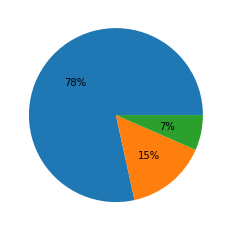

In [25]:
# Plotting the delay categories
input = flights_hurricane.groupby('Status')['Status'].count() #.plot(kind= 'pie', autopct = '%1.1f%%')
#plt.title("Delay in minutes")
plt.pie(input, autopct='%.0f%%')
plt.show()

## 4.5 Exploring Cancellations


In [26]:
#counting cancelled flights from US-origin airports during all of october
fh_dep_canc = (flights_hurricane['cancelled'] == 1).value_counts()
print(fh_dep_canc)

False    21919
True      1242
Name: cancelled, dtype: int64


In [27]:
#counting cancelled flights from US-origin airports between August 25. - August 31.
fh_katrina_canc = (flights_hurricane[(flights_hurricane['flight_date'] >= '2005-08-25') & (flights_hurricane['flight_date'] <= '2005-08-31')]['cancelled'] == 1).value_counts()
print(fh_katrina_canc)

False    4076
True     1009
Name: cancelled, dtype: int64


In [28]:
#Ratio from US-origin airports: cancellations during hurricane/total cancellations
fh_katrina_canc/fh_dep_canc*100.0

False    18.595739
True     81.239936
Name: cancelled, dtype: float64

In [29]:
#counting cancelled flights from airports with origin or destination in the hurricane michael area during all of october
hk_canc = (hurricane_katrina['cancelled'] == 1).value_counts()
print(hk_canc)

False    105134
True       3880
Name: cancelled, dtype: int64


In [30]:
#counting cancelled flights from airports with origin or destination in the Hurricane Katrina area during August 25. - 31.
hk_katrina_canc = (hurricane_katrina[(hurricane_katrina['flight_date'] >= '2005-08-25') & (hurricane_katrina['flight_date'] <= '2005-08-31')]['cancelled'] == 1).value_counts()
print(hk_katrina_canc)

False    22024
True      2166
Name: cancelled, dtype: int64


In [31]:
#Ratio from all cancellations with US-airport as origin or destination: cancellations during hurricane/total
hk_katrina_canc/hk_canc*100.0

False    20.948504
True     55.824742
Name: cancelled, dtype: float64

In [32]:
#counting cancelled flights from US-origin airports during all of october
fd_dest_canc = (flights_dest['cancelled'] == 1).value_counts()
print(fd_dest_canc)

False    21977
True      1175
Name: cancelled, dtype: int64


In [33]:
#counting cancelled flights from US-origin airports during october 10. - 15.
fd_katrina_canc = (flights_dest[(flights_dest['flight_date'] >= '2005-08-25') & (flights_dest['flight_date'] <= '2005-08-29')]['cancelled'] == 1).value_counts()
print(fd_katrina_canc)

False    2986
True      642
Name: cancelled, dtype: int64


In [34]:
#Ratio from US-destination airports: cancellations during hurricane/total
fd_katrina_canc/fd_dest_canc*100.0

False    13.586932
True     54.638298
Name: cancelled, dtype: float64

## 4.6 Planes flown to Origin and dest airports (three intervalls before event, afteer event Miami, after event New Orleans)

In [ ]:
#origin airports in the hurricane area where they fly to
airports_o = hurricane_katrina[hurricane_katrina['origin'].isin(['MSY', 'MEM', 'FLL','MIA','PBI','PNS'])]
airports_o = airports_o[['flight_date','origin','name_origin','cancelled','dest','name_dest']]
airports_o = airports_o[airports_o["cancelled"]==0]

#dest airports in the hurricane area where they fly 
airports_d = hurricane_katrina[hurricane_katrina['dest'].isin(['MSY', 'MEM', 'FLL','MIA','PBI','PNS'])]
airports_d = airports_d[['flight_date','origin','name_origin','cancelled','dest','name_dest']]
airports_d = airports_d[airports_d["cancelled"]==0]

In [ ]:
# Sort the origin airports by the dates of events (Before event, miami after event, new orleans after event)
airports_o_before = airports_o[(airports_o['flight_date'] >= '2005-08-01') & (airports_o['flight_date'] <= '2005-08-24')]
airports_o_after = airports_o[(airports['flight_date'] >= '2005-08-25') & (airports_o['flight_date'] <= '2005-08-31')]
airports_o_after_no = airports_o[(airports['flight_date'] >= '2005-08-29') & (airports_o['flight_date'] <= '2005-08-31')]

# Sort the dest airports by the dates of events (Before event, miami after event, new orleans after event)
airports_d_before = airports_d[(airports_d['flight_date'] >= '2005-08-01') & (airports_d['flight_date'] <= '2005-08-24')]
airports_d_after = airports_d[(airports_d['flight_date'] >= '2005-08-25') & (airports_d['flight_date'] <= '2005-08-31')]
airports_d_after_no = airports_d[(airports_d['flight_date'] >= '2005-08-29') & (airports_d['flight_date'] <= '2005-08-31')]

In [ ]:
#frequency how airports fly origin
airports_d_before_count = airports_d_before.groupby(["dest"], as_index=False)['flight_date'].count() \
    .rename(columns={"flight_date":"total"}) 

airports_d_after_count = airports_d_after.groupby(["dest"], as_index=False)['flight_date'].count() \
    .rename(columns={"flight_date":"total"}) 

airports_d_after_no_count = airports_d_after_no.groupby(["dest"], as_index=False)['flight_date'].count() \
    .rename(columns={"flight_date":"total"}) 
    
fig, axes = plt.subplots(1, 3,figsize=(20,10))

sns.barplot(ax=axes[0],x='total', y='dest',  data=airports_d_before_count,color='Gold')
axes[0].set_title('Frequency of flights before the event');

sns.barplot(ax=axes[1],x='total', y='dest',  data=airports_d_after_count,color='Gold')
axes[1].set_title('Frequency of flights when events starts in Miami');

sns.barplot(x='total', y='dest',  data=airports_d_after_no_count,color='Gold')
axes[2].set_title('Frequency of flights when the event starts in New Orleans');

In [ ]:
#frequency how airports fly dest
airports_o_before_count = airports_o_before.groupby(["origin"], as_index=False)['flight_date'].count() \
    .rename(columns={"flight_date":"total"}) 

airports_o_after_count = airports_o_after.groupby(["origin"], as_index=False)['flight_date'].count() \
    .rename(columns={"flight_date":"total"}) 

airports_o_after_no_count = airports_o_after_no.groupby(["origin"], as_index=False)['flight_date'].count() \
    .rename(columns={"flight_date":"total"}) 



fig, axes = plt.subplots(1, 3,figsize=(20,10))

sns.barplot(ax=axes[0],x='total', y='origin',  data=airports_o_before_count,color='brown');
axes[0].set_title('Frequency of flights before the event')

sns.barplot(ax=axes[1],x='total', y='origin',  data=airports_o_after_count,color='brown');
axes[1].set_title('Frequency of flights when events starts in Miami');

sns.barplot(x='total', y='origin',  data=airports_o_after_no_count,color='brown');
axes[2].set_title('Frequency of flights when the event starts in New Orleans');

# 5. Weather Data

## 5.1 Using the meteostat API (didn't work because callps per minute were exceeded)

In [35]:
from sql import api_key, api_host

In [ ]:
lat = ['33.56290054','36.1245002746582','35.035301208496094','39.998001','39.0488014221','39.90240097045898','26.072599','38.0364990234375','35.04240036010742','25.79319953918457','29.99340057373047','26.68320083618164'
'30.473400115967','38.1744','35.81100082','26.53619956970215']

lon = ['-86.75350189','-86.6781997680664','-85.20379638671875','-82.891899','-84.6678009033','-84.21939849853516','-80.152702','-84.60590362548828'
,'-89.97669982910156','-80.29060363769531','-90.25800323486328','-80.09559631347656','-87.186599731445','-85.736','-83.9940033','-81.75520324707031']

import requests
import pandas as pd

weather_df = pd.DataFrame([])

url = "https://meteostat.p.rapidapi.com/point/daily?"
time_start = "&start=2005-08-01"
time_end = "&end=2005-08-31"

for l1, l2 in zip(lat,lon):
    url_f = f'{url}lat={l1}&lon={l2}{time_start}{time_end}'
    print(url_f)

    res = requests.get(url_f, headers={"x-rapidapi-host": api_host,
                                        "x-rapidapi-key": api_key})
    weather = res.json()

    weather_temp_df = pd.json_normalize(weather,  
                                            record_path=["data"], 
                                            #meta= [["meta", "generated", "stations"]],
                                            errors='ignore')


    # Append data to dataframe
    weather_temp_df["lat"] = [l1 for i in weather_temp_df.index]
    weather_temp_df["lon"] = [l2 for i in weather_temp_df.index]
    weather_df = weather_df.append(weather_temp_df, ignore_index=True)
weather_df

In [ ]:
lat = [35.042400,26.072599,30.473400,25.793200,26.683201,29.993401]
lon = [-89.976700,-80.152702,-87.186600,-80.290604,-80.095596,-90.258003]

weather_df = pd.DataFrame([])

start = datetime(2005, 8, 1)
end = datetime(2005, 8, 31)

for l1, l2 in zip(lat, lon):
    test = Point(l1, l2)

    data = Daily(test, start, end)
    data = data.fetch()

    data['lat'] = l1
    data['lon'] = l2
    data.reset_index(level = 0, inplace=True) 

    weather_df = weather_df.append(data)
weather_df

## 5.2 Using the meteostat library

In [ ]:
#winspeed and precipitation for memphis
start = datetime(2005, 8, 1)
end = datetime(2005, 8, 31)
# Create Point for Vancouver, BC
miami = Point(25.79319953918457, -80.29060363769531)
# Get daily data for 2018
data = Daily(miami, start, end)
data = data.fetch()
# Plot line chart including average, minimum and maximum temperature
data.plot(y=['wspd', 'wpgt', 'prcp'])
plt.show()

In [ ]:
#winspeed and precipitation for memphis
start = datetime(2005, 8, 1)
end = datetime(2005, 8, 31)
# Create Point for Vancouver, BC
new_orleans = Point(29.99340057373047, -90.25800323486328)
# Get daily data for 2018
data2 = Daily(new_orleans, start, end)
data2 = data2.fetch()
# Plot line chart including average, minimum and maximum temperature
data2.plot(y=['wspd', 'wpgt', 'prcp'])
plt.show()

In [ ]:
#winspeed and precipitation for memphis
start = datetime(2005, 8, 1)
end = datetime(2005, 8, 31)
# Create Point for Vancouver, BC
memphis = Point(35.042400,-89.976700)
# Get daily data for 2018
data7 = Daily(memphis, start, end)
data7 = data7.fetch()
# Plot line chart including average, minimum and maximum temperature
data7.plot(y=['wspd','prcp'])
plt.legend(['Average wind speed in km/h','Daily precipitation in l/m²'])
plt.title('Weather 2005')
plt.xlabel('Day')
plt.show()

In [ ]:
#Miami variables
delay_miami = hurricane_katrina.query("faa_origin == 'MIA'")['dep_delay']
cancelled_miami = hurricane_katrina.query("faa_origin == 'MIA'").groupby('flight_date').sum()['cancelled']
days = hurricane_katrina.query("faa_origin == 'MIA'")['flight_date']
diverted_miami = hurricane_katrina.query("faa_origin == 'MIA'").groupby('flight_date').sum()['diverted']

In [ ]:
#New Orleans variables
delay_no = hurricane_katrina.query("faa_origin == 'MSY'")['dep_delay']
cancelled_no = hurricane_katrina.query("faa_origin == 'MSY'").groupby('flight_date').sum()['cancelled']
days = hurricane_katrina.query("faa_origin == 'MSY'")['flight_date']
diverted_no = hurricane_katrina.query("faa_origin == 'MSY'").groupby('flight_date').sum()['diverted']

In [ ]:
#Miami: comparing delays and windspeed
fig, ax1 = plt.subplots(figsize = (16,9))
ax1.set_title('Delays and windspeed in Miami', fontsize = 20)
ax2 = ax1.twinx()
ax1.bar(days,delay_miami, color = 'grey')
ax2.plot(np.sort(days.unique()),data['wspd'], color = 'red')
ax1.set_xlabel('days', fontsize = 15)
ax1.set_ylabel('delay', fontsize = 15)
ax2.set_ylabel('windspeed', fontsize = 15)

In [ ]:
#Miami: comparing delays and precipitation
fig, ax1 = plt.subplots(figsize = (16,9))
ax1.set_title('Delays and precipitation in Miami', fontsize = 20)
ax2 = ax1.twinx()
ax1.bar(days,delay_miami, color = 'grey')
ax2.plot(np.sort(days.unique()),data['prcp'], color = 'red')
ax1.set_xlabel('days', fontsize = 15)
ax1.set_ylabel('delay', fontsize = 15)
ax2.set_ylabel('precipitation', fontsize = 15)

In [ ]:
#Miami: comparing cancellations and windspeed
fig, ax1 = plt.subplots(figsize = (16,9))
ax1.set_title('Cancellations and windspeed in Miami', fontsize = 20)
ax2 = ax1.twinx()
ax1.bar(np.sort(days.unique()),cancelled_miami, color = 'grey')
ax2.plot(np.sort(days.unique()),data['wspd'], color = 'red')
ax1.set_xlabel('days', fontsize = 15)
ax1.set_ylabel('cancellations', fontsize = 15)
ax2.set_ylabel('windspeed', fontsize = 15)

In [ ]:
#Miami: comparing cancellations and precipitation
fig, ax1 = plt.subplots(figsize = (16,9))
ax1.set_title('Cancellations and precipitation in Miami', fontsize = 20)
ax2 = ax1.twinx()
ax1.bar(np.sort(days.unique()),cancelled_miami, color = 'grey')
ax2.plot(np.sort(days.unique()),data['prcp'], color = 'red')
ax1.set_xlabel('days', fontsize = 15)
ax1.set_ylabel('cancellations', fontsize = 15)
ax2.set_ylabel('precipitation', fontsize = 15)

In [ ]:
#New Orleans: Comparing cancellations and windspeed
fig, ax1 = plt.subplots(figsize = (16,9))
ax1.set_title('Cancellations and windspeed in New Orleans', fontsize = 20)
ax2 = ax1.twinx()
ax1.bar(np.sort(days.unique()),cancelled_no, color = 'grey')
ax2.plot(np.sort(days.unique()),data2['wspd'], color = 'red')
ax1.set_xlabel('days', fontsize = 15)
ax1.set_ylabel('cancellations', fontsize = 15)
ax2.set_ylabel('windspeed', fontsize = 15)

In [ ]:
#New Orleans: Comparing cancellations and precipitation
fig, ax1 = plt.subplots(figsize = (16,9))
ax1.set_title('Cancellations and precipitation in New Orleans', fontsize = 20)
ax2 = ax1.twinx()
ax1.bar(np.sort(days.unique()),cancelled_no, color = 'grey')
ax2.plot(np.sort(days.unique()),data2['prcp'], color = 'red')
ax1.set_xlabel('days', fontsize = 15)
ax1.set_ylabel('cancellations', fontsize = 15)
ax2.set_ylabel('precipitation', fontsize = 15)

In [ ]:
#New Orleans: comparing delays and windspeed
fig, ax1 = plt.subplots(figsize = (16,9))
ax1.set_title('Delays and windspeed in New Orleans', fontsize = 20)
ax2 = ax1.twinx()
ax1.bar(days,delay_no, color = 'grey')
ax2.plot(np.sort(days.unique()),data2['wdsp'], color = 'red')
ax1.set_xlabel('days', fontsize = 15)
ax1.set_ylabel('delay', fontsize = 15)
ax2.set_ylabel('windspeed', fontsize = 15)

In [ ]:
#New Orleans: comparing delays and precipitation
fig, ax1 = plt.subplots(figsize = (16,9))
ax1.set_title('Delays and precipitation in New Orleans', fontsize = 20)
ax2 = ax1.twinx()
ax1.bar(days,delay_no, color = 'grey')
ax2.plot(np.sort(days.unique()),data2['prcp'], color = 'red')
ax1.set_xlabel('days', fontsize = 15)
ax1.set_ylabel('delay', fontsize = 15)
ax2.set_ylabel('precipitation', fontsize = 15)

# 6.GeoMap USA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lets_plot import *
LetsPlot.setup_html()


LetsPlot.set(maptiles_zxy(
    url='https://gibs.earthdata.nasa.gov/wmts/epsg3857/best/VIIRS_CityLights_2012/default//GoogleMapsCompatible_Level8/{z}/{y}/{x}.jpg',
    attribution='<a href="https://earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/gibs">© NASA Global Imagery Browse Services (GIBS)</a>',
    max_zoom=8
))
from lets_plot.geo_data import *
from lets_plot import tilesets
LetsPlot.set(tilesets.STAMEN_DESIGN_TERRAIN_HIRES)
countries_gcoder = geocode_countries(['USA'])
countries_gcoder.get_geocodes()

In [ ]:
visu2 = query("SELECT faa AS airport_code,name,lat,lon,city,country FROM muc_analytics_21_1.airports WHERE faa IN ('MSY', 'MEM', 'FLL','MIA','PBI','PNS')") #sql get_data function

visu2['enplanement'] = ['7.775.147','11.000.000','22.390.285','31.008.453','7.014.237','1.638.605']

visu2

In [ ]:
(ggplot() 
 + geom_livemap(location=[-99.7426055742426, 37.2502586245537],
                zoom=4)
 + geom_polygon(aes(fill='country'), 
                data=countries_gcoder.get_boundaries(), 
                alpha=.2)
 + geom_point(aes('lon', 'lat', fill='country'),
 
              data=visu,
              shape=28,
              alpha=.9,
              color='red',
              tooltips=layer_tooltips()
                        .format('passengers', '{.1f} m' )
                        .format('^x', '.2f').format('^y', '.2f')
                        .line('@|@iata')
                        .line('Passengers|@passengers') 
                        .line('City|@city') 
                        .line('country|@country') 
                        .line('lon|^x')
                        .line('lat|^y')
                        .color("dark_magenta"))
 + scale_fill_manual(values=['#30a2da', '#fc4f30'])
 + scale_size(range=[10, 40], trans='sqrt')
 + theme(legend_position='none')
 + ggsize(900, 520)
 + scale_fill_brewer(palette="PuRd", limits=[0, 52.5], trans="sqrt")
 + ggtitle('US States')
 + theme(panel_grid='blank'))